# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [28]:
# book-keeping variables (optional; for this box only)
#volume = '../../../PG1411/pg1411/'
volume = '' # base directory
gal = 'pg1411' # prefix label for output files

# Input files
infile = volume+'pg1411rb3.fits' # path + name of your input cube
qsotemplate = volume+gal+'qsotemplate.npy' 
stellartemplates = volume+gal+'hosttemplate.npy'

# Output directories/files
outdir = volume+'' # path + name of directory for saving the output files
path_to_npy_file = volume+'' # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'
#mapdir = '' # directory for saving the output maps; needed for makemaps.py when it is running

Some general information about your cube:

In [3]:
ncols = 17 # number of columns
nrows = 26 # number of rows
# centcol = 9.002
# centrow = 14.002
platescale = 0.3
fitrange = [4620,7450] #in Angstrom

if not os.path.isfile(infile): print('Data cube not found.')

Data cube not found.


### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [4]:
lines = ['Halpha','Hbeta', '[OI]6300','[OI]6364','[OIII]4959','[OIII]5007', '[NII]6548','[NII]6583','[SII]6716','[SII]6731']

How many components do you want to be fitted to the emission lines?

In [5]:
maxncomp = 1

In [6]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = 'Halpha'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    ncomp[i][8,13] = 0
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.0898)
    siginit_gas[i] = np.full(maxncomp,50)
    zinit_gas[i][2,18,:]=0.091
    zinit_gas[i][4,21:22,:]=0.091
    zinit_gas[i][5,21,:]=0.091
    zinit_gas[i][6:8,23:25,:]=0.091
    zinit_gas[i][1:4,1:7,:]=0.0894
    zinit_gas[i][6:16,0:7,:]=0.089
    zinit_gas[i][11,8:9,:]=0.089
    zinit_stars=np.full((ncols,nrows),0.0898)

# Tweaked regions are around HeII,Hb/[OIII],HeI5876/NaD,[OI],Halpha, and [SII]
# Lower and upper wavelength for re-fit
tw_lo = [4600,5200,6300,6800,7000,7275]
tw_hi = [4800,5500,6500,7000,7275,7375]
# Number of wavelength regions to re-fit
tw_n = len(tw_lo)
# Fitting orders
deford = 1
tw_ord = np.full(tw_n,deford)
# Parameters for continuum fit
# In third dimension:
#   first element is lower wavelength limit
#   second element is upper
#   third is fit order
tweakcntfit = np.full((ncols,nrows,3,tw_n),0)
tweakcntfit[:,:,0,:] = tw_lo
tweakcntfit[:,:,1,:] = tw_hi
tweakcntfit[:,:,2,:] = tw_ord

# Velocity dispersion limits and fixed values
siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 500]
# lratfix = {'[NI]5200/5198': [1.5]}

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [7]:
argspltlin1 = {'nx': 3,
               'ny': 2,
               'line': ['', 'Hbeta', '[OIII]4959', '[OI]6300', 'Halpha', '[SII]6716'],
               'size': [0., 75., 125., 125., 100., 100.]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [29]:
initproc = { \
        # Required pars
        'fitran': fitrange,
        'fluxunits': 1e-15,  # erg/s/cm^2/arcsec^2
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': 'PG1411+442',
        'ncomp': ncomp,
        # 'mapdir': mapdir,
        'outdir': outdir,
        'platescale': platescale,
        'positionangle': 335,
        'minoraxispa': 75,
        'zinit_stars': zinit_stars,
        'zinit_gas': zinit_gas,
        'zsys_gas': 0.0898,
        # Optional pars
        'argscheckcomp': {'sigcut': 3,
                          'ignore': ['[OI]6300', '[OI]6364',
                                     '[SII]6716', '[SII]6731']},
        'argscontfit': {'blrpar': [0, 7150, 5000/299792*7150,
                                   0, 5300, 5000/299792*5300],
                        'qsoxdr': qsotemplate,
                        'siginit_stars': 50,
                        'uselog': 1,
                        'refit': 1},
        'argsreadcube': {'waveunit_in': 'Angstrom',
                         'waveunit_out': 'Angstrom',
                         'fluxunit_in': 'erg/s/cm2/Angstrom/sr',
                         'fluxunit_out': 'erg/s/cm2/Angstrom/sr'},
        'argscontplot': {'xstyle':'lin',
                         'ystyle':'lin',
                         'waveunit_in': 'Angstrom',
                         'waveunit_out': 'Angstrom',
                         'fluxunit_in':'flambda',
                         'fluxunit_out':'flambda',
                         'mode':'dark'},
        'argslinelist': {'vacuum': False,
                         'waveunit': 'Angstrom'},
        'startempfile': stellartemplates,
        'argspltlin1': argspltlin1,
        'decompose_qso_fit': 1,
        # 'remove_scattered': 1,
        'fcncheckcomp': 'checkcomp',
        'fcncontfit': 'fitqsohost',
        'maskwidths_def': 500,
        # 'tweakcntfit': tweakcntfit,
        'emlsigcut': 2,
        'logfile': logfile,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'siginit_stars': 50,
        'cutrange': np.array([6410, 6430]),
        'nocvdf': 1,
        # 'cvdf_vlimits': [-3e3,3e3],
        # 'cvdf_vstep': 10d,
        # 'host': {'dat_fits': volume+'ifs/gmos/cubes/'+gal+'/'+\
        #         gal+outstr+'_host_dat_2.fits'} \
    }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [ ]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [30]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [31]:
cols = [14]
rows = [11]

[[Variables]]
    continuum_additive_polynomiala:  1.30744337 (init = 0)
    continuum_additive_polynomialb:  0.43385130 (init = 0)
    continuum_additive_polynomialc: -1.55391259 (init = 0)
    continuum_additive_polynomiald: -0.08757296 (init = 0)
    continuum_additive_polynomiale:  4.3327e-15 (init = 0)
    continuum_additive_polynomialf: -2.4098e-16 (init = 0)
    continuum_additive_polynomialg:  1.8652e-16 (init = 0)
    continuum_additive_polynomialh:  2.8042e-17 (init = 0)
    exp_scale_a:                     0.64769670 (init = 0)
    exp_scale_b:                     3.0948e-07 (init = 0)
    exp_scale_c:                     0.02517786 (init = 0)
    exp_scale_d:                     0.00884878 (init = 0)
    exp_scale_e:                     1.3292e-12 (init = 0)
    exp_scale_f:                     1.3291e-12 (init = 0)
    exp_scale_g:                     0.07151954 (init = 0)
    exp_scale_h:                     0.06552485 (init = 0)
    g_7150amplitude:                 2.604

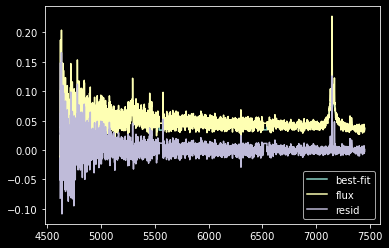

[[Variables]]
    continuum_additive_polynomiala:  1.23163913 (init = 0)
    continuum_additive_polynomialb:  0.33130521 (init = 0)
    continuum_additive_polynomialc: -1.52841871 (init = 0)
    continuum_additive_polynomiald: -0.06673929 (init = 0)
    continuum_additive_polynomiale: -1.2090e-16 (init = 0)
    continuum_additive_polynomialf:  1.2718e-16 (init = 0)
    continuum_additive_polynomialg:  3.0639e-16 (init = 0)
    continuum_additive_polynomialh:  1.7149e-16 (init = 0)
    exp_scale_a:                     0.93285283 (init = 0)
    exp_scale_b:                     4.3498e-07 (init = 0)
    exp_scale_c:                     3.9699e-04 (init = 0)
    exp_scale_d:                     0.00866874 (init = 0)
    exp_scale_e:                     2.2517e-12 (init = 0)
    exp_scale_f:                     2.2517e-12 (init = 0)
    exp_scale_g:                     0.06175627 (init = 0)
    exp_scale_h:                     0.05961047 (init = 0)
    g_7150amplitude:                 8.543

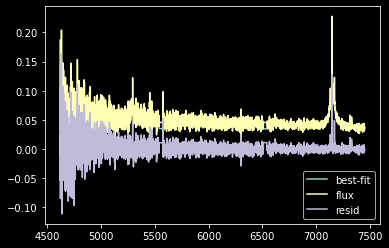

In [32]:
q3df(initproc,cols=cols,rows=rows)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

CUBE: Negative values encountered in variance array.Taking absolute value.
CUBE: WMAP extension does not exist.


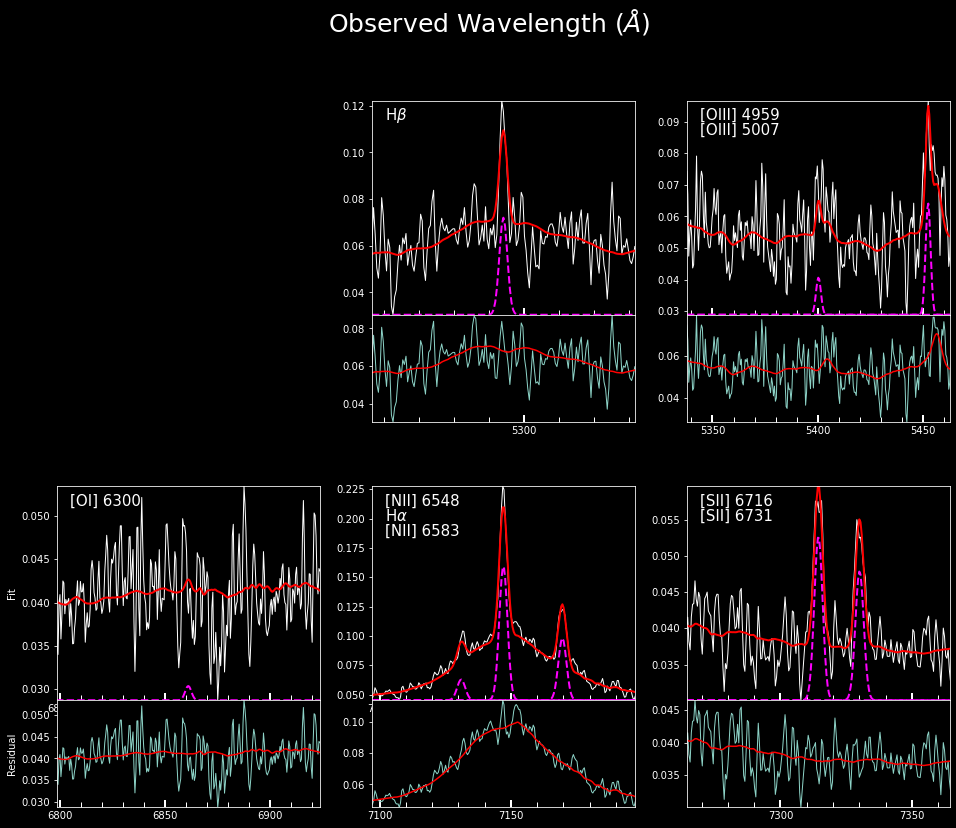

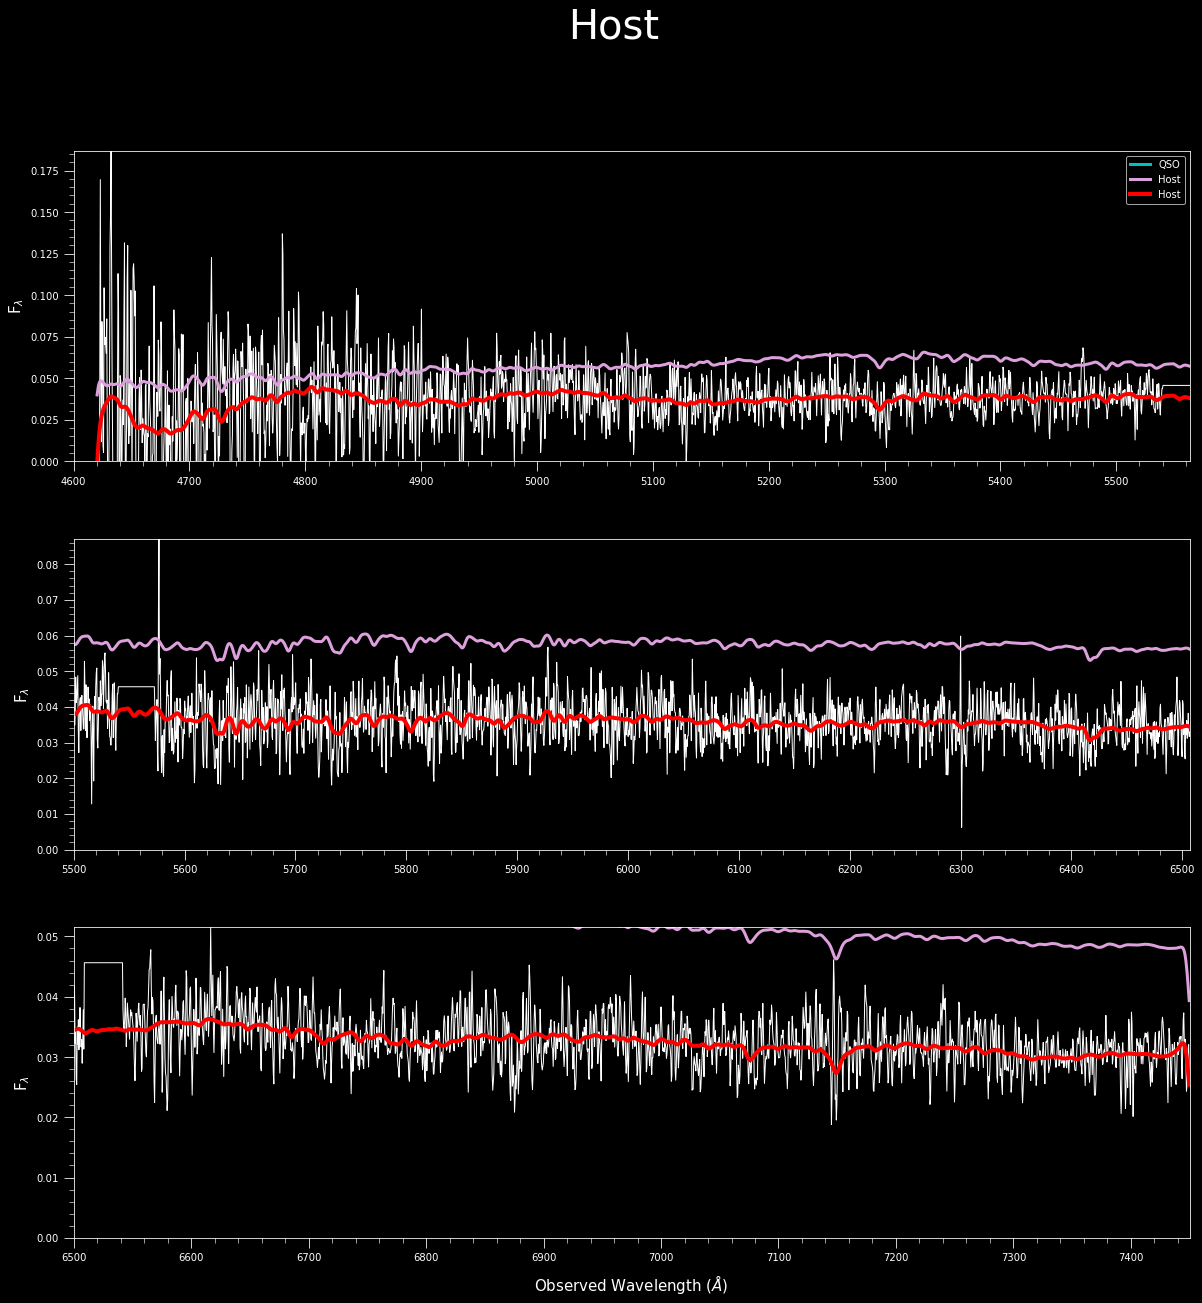

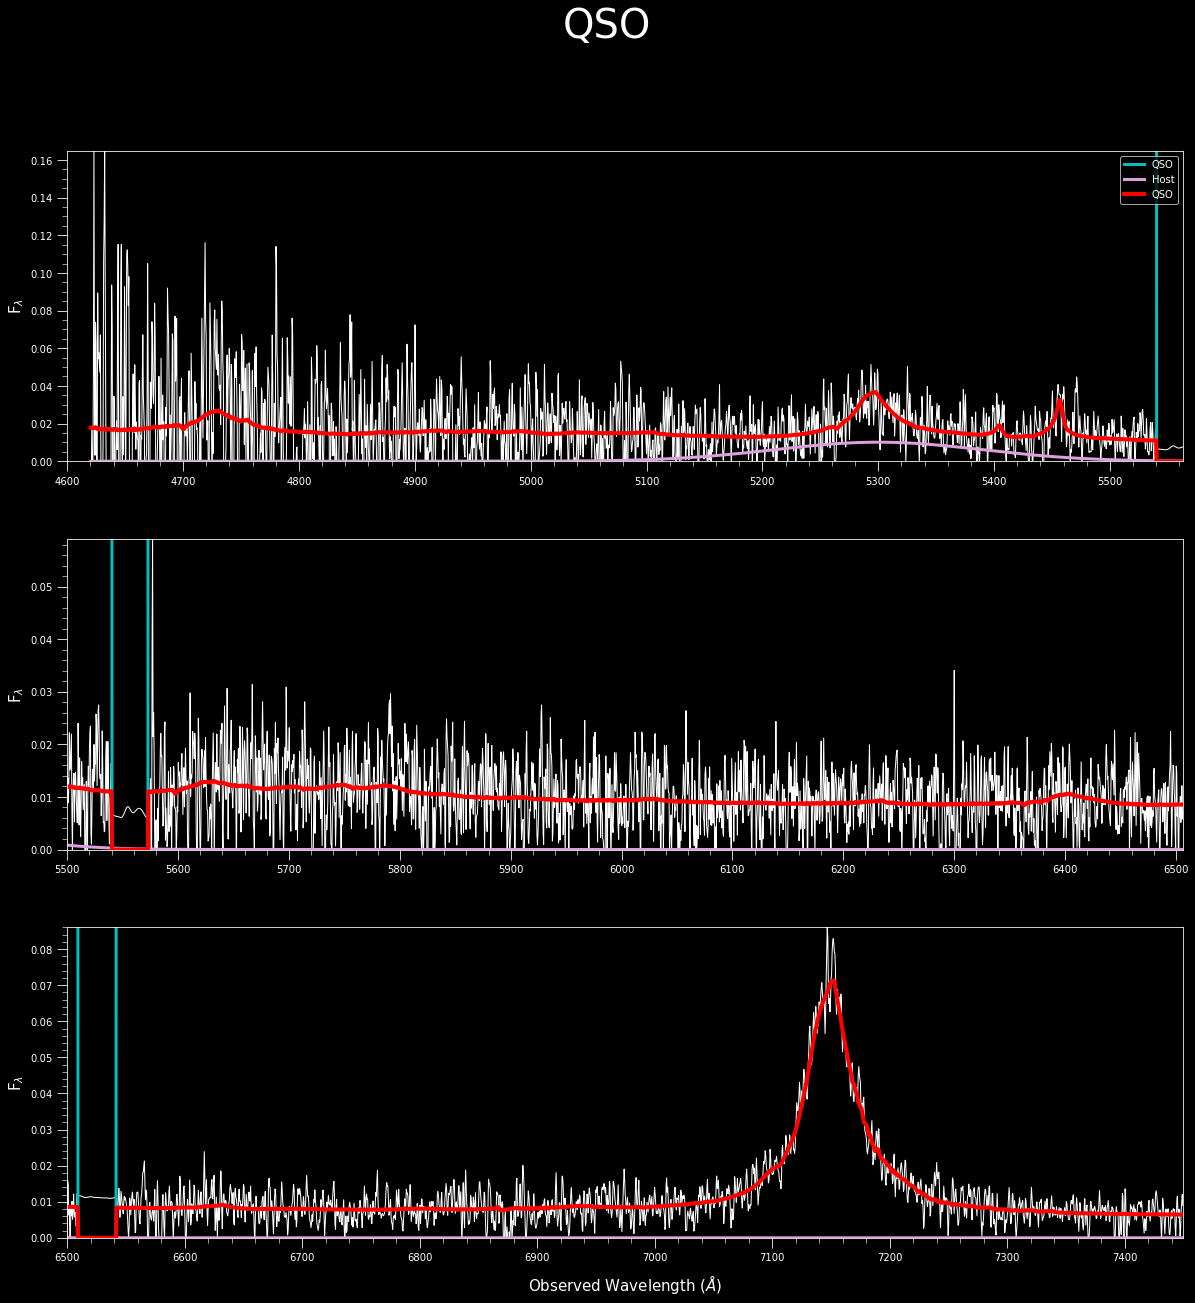

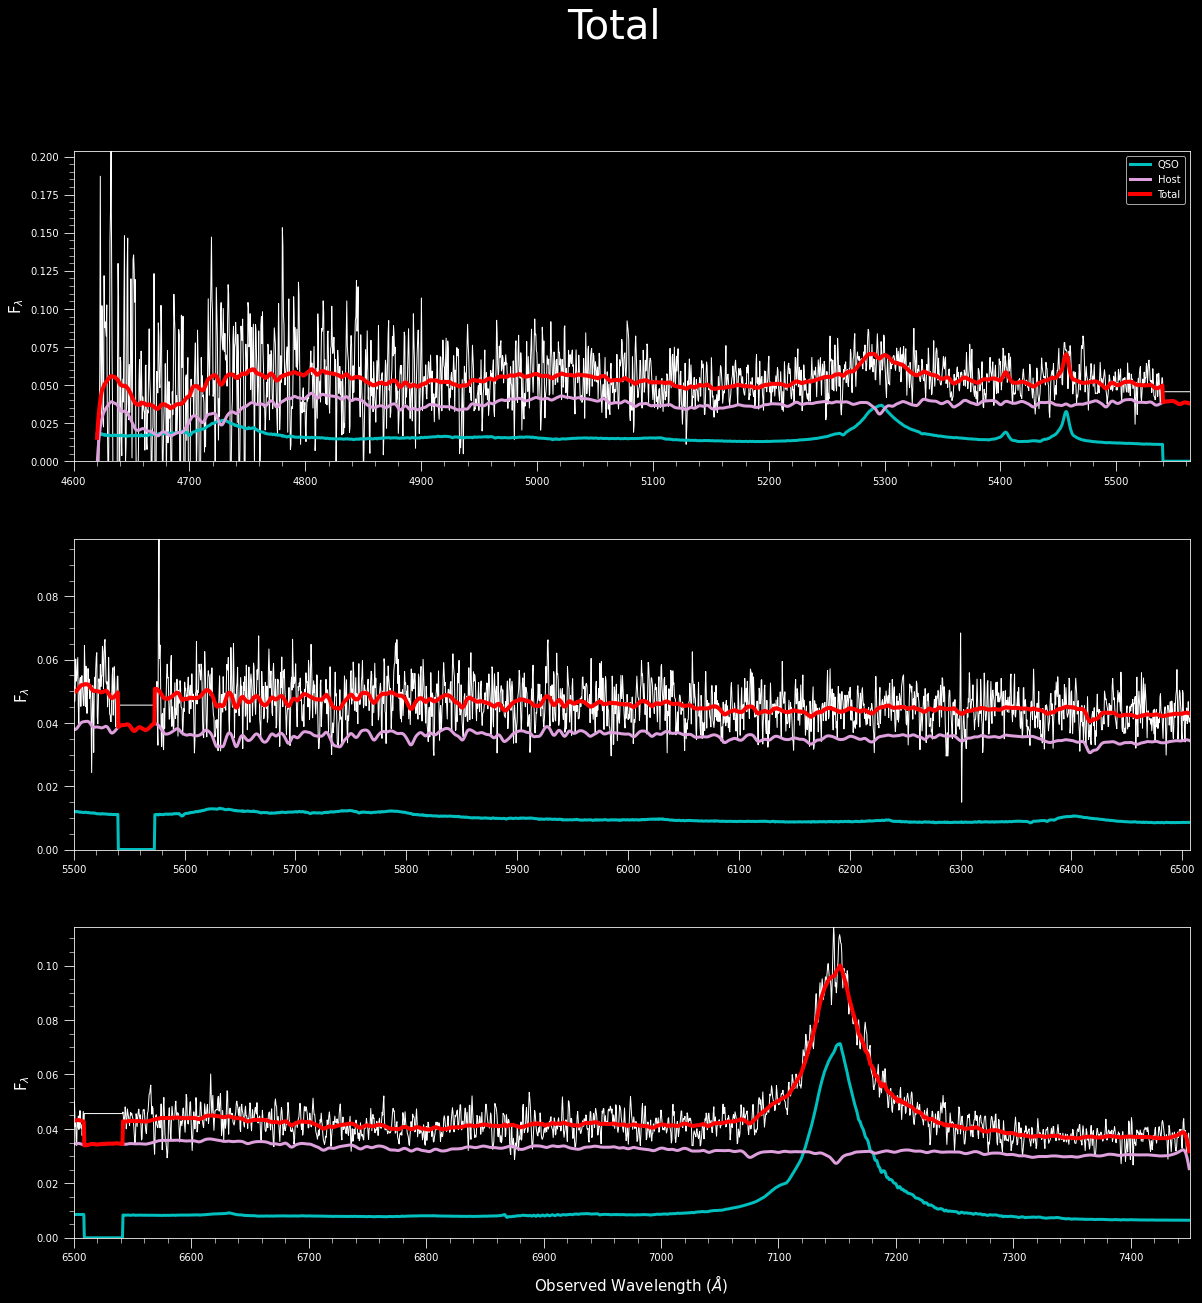

In [33]:
%matplotlib inline
q3da(initproc,cols=cols,rows=rows)

Plots in an external, interactive window:

In [ ]:
%matplotlib
q3da(initproc,cols=cols,rows=rows)